In [1]:
import logging
import os
import functools
import datetime

import numpy as np
import scipy.optimize as optim

import simulacra as si
import simulacra.units as u

import ionization as ion

import matplotlib.patches as mpatches
import matplotlib.lines as mlines

LOGMAN = si.utils.LogManager('simulacra', 'ionization', stdout_level = logging.INFO)
THIS_DIR = os.getcwd()
OUT_DIR = os.path.join(THIS_DIR, 'out', 'Bauer1999')
SIM_LIB = os.path.join(OUT_DIR, 'SIMLIB')

PLOT_KWARGS = dict(
    show = True,
    save = True,
    target_dir = OUT_DIR,
    img_format = 'png',
    fig_dpi_scale = 6,
)

CHECKPOINT_KWARGS = dict(
    checkpoints = True,
    checkpoint_dir = SIM_LIB,
    checkpoint_every = datetime.timedelta(minutes = 1),
)

%matplotlib inline

In [2]:
class UnipolarGaussianPulse(ion.potentials.UniformLinearlyPolarizedElectricPotential):
    def __init__(
        self,
        omega,
        tau,
        cep,
        amplitude,
        **kwargs,
    ):
        self.omega = omega
        self.tau = tau
        self.cep = cep
        self.amplitude = amplitude
        
        super().__init__(**kwargs)
        
    @classmethod
    def from_period(cls, period, tau, cep, amplitude, **kwargs):
        return cls(
            u.twopi / period,
            tau,
            cep,
            amplitude,
            **kwargs,
        )
        
        
    def get_electric_field_amplitude(self, t):
        return self.amplitude * np.exp(-((t / self.tau) ** 2)) * np.cos((self.omega * t) + self.cep)
    
    @property
    def period(self):
        return u.twopi / self.omega
    
    @property
    def electric_area(self):
        return np.sqrt(u.pi) * self.amplitude * self.tau * np.exp(-((self.omega * self.tau) ** 2) / 4) * np.cos(self.cep)
    
    def info(self):
        info = super().info()
        
        info.add_field('omega', self.omega)
        info.add_field('Period', f'{u.uround(self.period, u.asec)} asec')
        info.add_field('tau', f'{u.uround(self.tau, u.asec)} asec')
        info.add_field('CEP', self.cep)
        info.add_field('Amplitude', f'{u.uround(self.amplitude, u.atomic_electric_field)} AEF')
        info.add_field('Electric Area', f'{u.uround(self.electric_area, u.atomic_electric_field * u.atomic_time)} AEF')
        
        return info

In [17]:
pulse = UnipolarGaussianPulse.from_period(
    period = 500 * u.asec,
    tau = 500 * u.asec,
    cep = 0,
    amplitude = 1e12 * u.V_per_m,
)

In [18]:
qho = ion.potentials.HarmonicOscillator.from_frequency_and_mass(
    omega = 18.85e15 / u.sec,
    mass = u.electron_mass,
)

In [19]:
pulse.period / qho.period(u.electron_mass)

1.5000353386411136

In [20]:
states = [ion.states.QHOState.from_potential(qho, mass = u.electron_mass, n = n) for n in range(10)]

In [22]:
spec = ion.mesh.LineSpecification(
    'test',
    time_initial = -2000 * u.asec,
    time_final = 2000 * u.asec,
    internal_potential = qho,
    electric_potential = pulse,
    test_states = states,
    initial_state = states[0],
    z_bound = 10 * u.nm,
    z_points = 2 ** 10,
)
sim = spec.to_sim()
print(sim.info())

MeshSimulation(test) {initialized}
├─ UUID: 8b3ed559-9f5a-43a3-9d2f-18d3fc0d4305
├─ Status: initialized
│  ├─ Initialization Time: 2018-08-27 20:58:24.330327
│  ├─ Latest Run Time: None
│  ├─ End Time: None
│  ├─ Running Time: 0:00:00
│  └─ Elapsed Time: None
├─ LineSpecification(test)
│  ├─ UUID: e1340db5-b6ce-4376-811a-2c284cab2672
│  ├─ Checkpointing: disabled
│  ├─ Animation: none
│  ├─ Time Evolution
│  │  ├─ Initial State: |0>
│  │  ├─ Initial Time: -2000 as | -2 fs | -82.68 a.u.
│  │  ├─ Final Time: 2000 as | 2 fs | 82.68 a.u.
│  │  └─ Time Step: 1 as | 0.001 fs | 0.041 a.u.
│  ├─ Operators and Evolution Algorithm
│  │  ├─ LineLengthGaugeOperators
│  │  └─ AlternatingDirectionImplicit
│  ├─ Potentials and Masks
│  │  ├─ DC Correct Electric Field: no
│  │  ├─ HarmonicOscillator
│  │  │  ├─ Spring Constant: 323.7 N/m | 0.208 a.u./a_0
│  │  │  ├─ Center: 0 a_0 | 0 nm
│  │  │  └─ Cutoff Distance: None
│  │  ├─ UnipolarGaussianPulse
│  │  │  ├─ omega: 1.2566370614359172e+16
│  │  │  

In [23]:
sim.run(progress_bar = True)

100%|######################################| 4000/4000 [00:12<00:00, 311.99it/s]


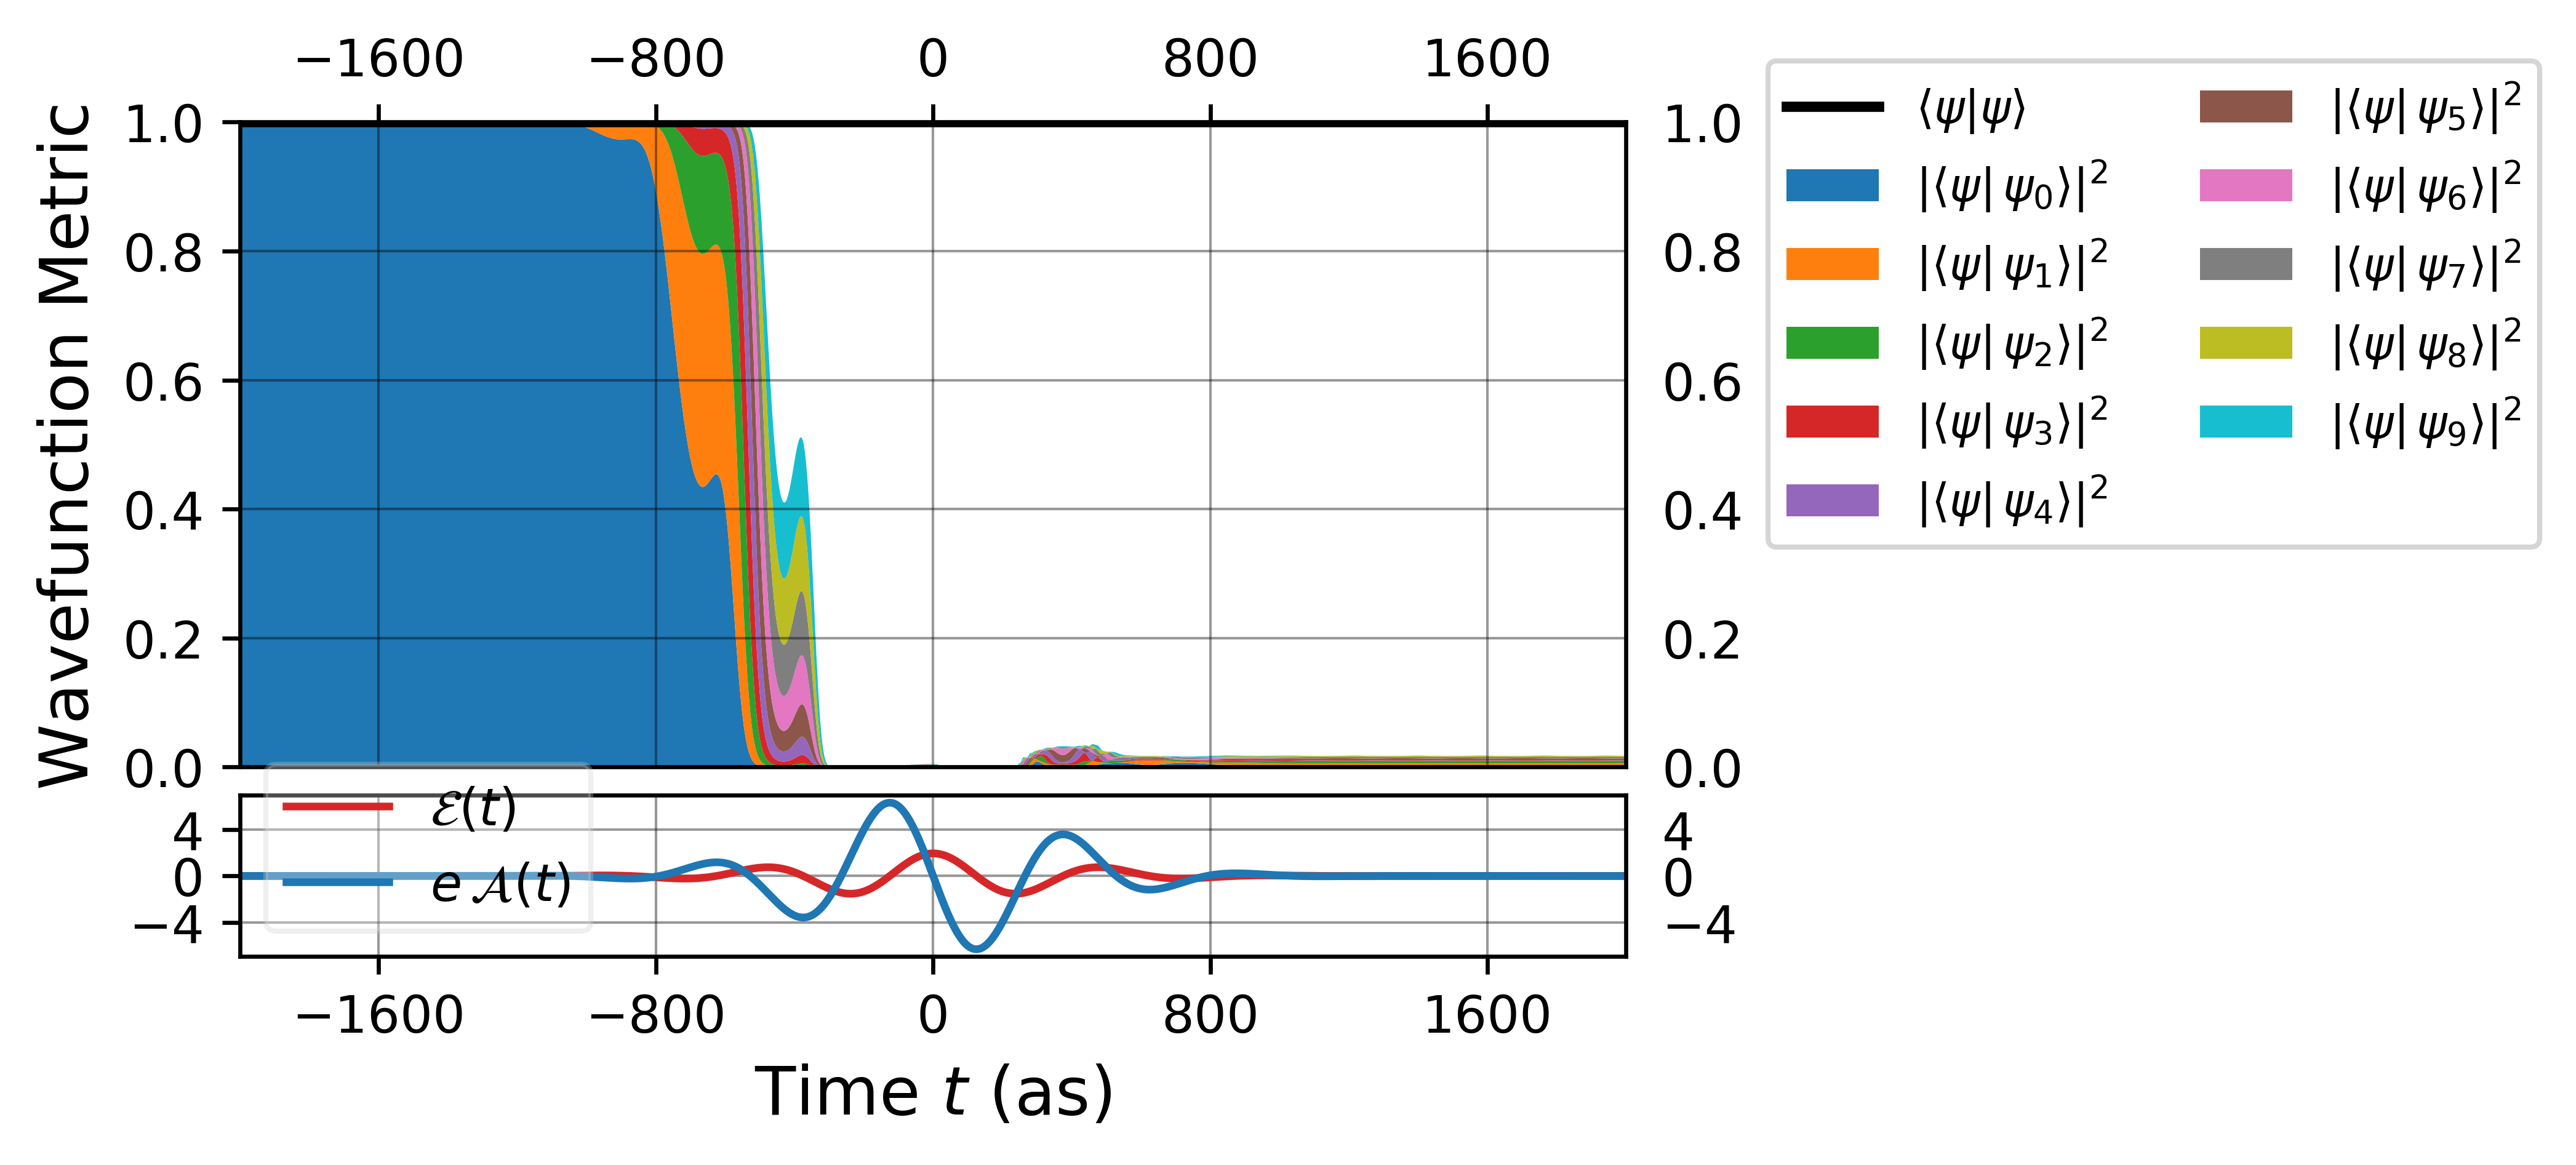

In [24]:
sim.plot.state_overlaps_vs_time(**PLOT_KWARGS)